## Let's dive into our model's predictions for stage 1

**Questions to ask:**
  - Which games did it get wrong?
  - What do those games have in common?
  - Would including those features be risking "overfitting" to these few years (2015-2019)?

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss

## Utility Scripts
import sys
sys.path.append("../")
import data_utils as du  ## one made by us


os.chdir("../../data/men")

In [8]:
## Provided files
teams = pd.read_csv("MTeams.csv")
seeds = pd.read_csv("MNCAATourneySeeds.csv")
tourney_results = pd.read_csv("MNCAATourneyCompactResults.csv")
teams_and_seeds = teams.merge(seeds)

## Our submission
submission = pd.read_csv("subs/submission_probs_2021-03-02.csv")

## Create matching ID on tourney_results
tourney_results['ID'] = tourney_results.apply(lambda x: f"{x['Season']}_{x['WTeamID']}_{x['LTeamID']}"
                                              if x['WTeamID'] < x['LTeamID']
                                              else f"{x['Season']}_{x['LTeamID']}_{x['WTeamID']}", axis=1)
## Create binary target
tourney_results['Team1_Win'] = tourney_results.apply(lambda x: 1 if x['WTeamID'] < x['LTeamID'] else 0, axis=1)

## Merge with predictions and calculate a residual
tourney_results = tourney_results.merge(submission)
tourney_results['residual'] = tourney_results['Team1_Win'] - tourney_results['Pred']
tourney_results['abs_residual'] = np.abs(tourney_results['residual'])

## Merge in team names and seeds
teams_and_seeds = teams_and_seeds.rename(columns = {'TeamName': 'WTeamName',
                                                    'Seed': 'WSeed',
                                                    'TeamID': 'WTeamID'})
tourney_results = tourney_results.merge(teams_and_seeds)
teams_and_seeds = teams_and_seeds.rename(columns = {'WTeamName': 'LTeamName',
                                                    'WSeed': 'LSeed',
                                                    'WTeamID': 'LTeamID'})
tourney_results = tourney_results.merge(teams_and_seeds)

### Biggest misclassifications

Which games were we most confident in that ended up being the biggest upsets according to our model?

In [9]:
pd.options.display.max_columns = None

tourney_results[['Season', 'WTeamName', 'LTeamName', 'WScore', 'LScore', 'WSeed', 'LSeed',
                 'Pred','abs_residual']].drop_duplicates().sort_values('abs_residual', ascending = False).head(20)

,Season,WTeamName,LTeamName,WScore,LScore,WSeed,LSeed,Pred,abs_residual
84,2016,MTSU,Michigan St,90,81,X15,X02,0.958731,0.958731
20,2015,UAB,Iowa St,60,59,X14,X03,0.921495,0.921495
14,2015,NC State,Villanova,71,68,W08,W01,0.125047,0.874953
206,2018,Marshall,Wichita St,81,75,W13,W04,0.137822,0.862178
9,2015,Georgia St,Baylor,57,56,Z14,Z03,0.840573,0.840573
98,2016,Syracuse,Virginia,68,62,X10,X01,0.160259,0.839741
111,2017,USC,SMU,66,65,W11b,W06,0.827173,0.827173
167,2018,Syracuse,Michigan St,55,53,X11b,X03,0.824245,0.824245
60,2016,Ark Little Rock,Purdue,85,83,X12,X05,0.195801,0.804199
261,2019,UC Irvine,Kansas St,70,64,Z13,Z04,0.785870,0.785870


In [11]:
tourney_results[tourney_results['LTeamName'] == 'Virginia']

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ID,Team1_Win,Pred,residual,abs_residual,WTeamName,FirstD1Season,LastD1Season,WSeed,LTeamName,LSeed
42,2015,139,1277,60,1438,54,N,0,2015_1277_1438,1,0.222246,0.777754,0.777754,Michigan St,1985,2021,W07,Virginia,W02
98,2016,146,1393,68,1438,62,N,0,2016_1393_1438,1,0.160259,0.839741,0.839741,Syracuse,1985,2021,X10,Virginia,X01
115,2017,138,1196,65,1438,39,N,0,2017_1196_1438,1,0.485152,0.514848,0.514848,Florida,1985,2021,W04,Virginia,W05


Observations:
 - NCSU with the 3rd biggest upset between 2015 and 2019!
 - Where is UVA vs. UMBC in 2018??  Maybe they didn't want to evaluate us on that in Stage 1?
 - Don't think we should worry about missing huge upsets like most of the above.  Although, we should consider "trimming" predictions to protect ourselves from disaster, discussed below.

### Do we need to "trim" our predictions to minimize log-loss?

See this [this notebook](https://www.kaggle.com/luisgarcia/should-you-have-trimmed-your-predictions-probably) for an overview of why it can be beneficial to trim confident predictions under the log-loss evaluation metric.

From the notebook:

    We search for  α  in the interval  [0,1/4]  to find the ideal  α . The function trimmed_loss(alpha) computes the log loss of the trimmed predictions against the truth. The minimum value is labeled in the plot and we see that some amount of trim would have benefited me in this competition, but too much trim is detrimental. The amount we shave off is actually minimal, but this can still lead to big movements on the leaderboard.

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss

os.chdir("../../data/men")

## Results
tourney_results = pd.read_csv("MNCAATourneyCompactResults.csv")

## Our submission
submission = pd.read_csv("subs/submission_probs_2021-03-02.csv")

## Create matching ID on tourney_results
tourney_results['ID'] = tourney_results.apply(lambda x: f"{x['Season']}_{x['WTeamID']}_{x['LTeamID']}"
                                              if x['WTeamID'] < x['LTeamID']
                                              else f"{x['Season']}_{x['LTeamID']}_{x['WTeamID']}", axis=1)
## Create binary target
tourney_results['Team1_Win'] = tourney_results.apply(lambda x: 1 if x['WTeamID'] < x['LTeamID'] else 0, axis=1)

## Merge with predictions and calculate a residual
tourney_results = tourney_results.merge(submission)
tourney_results['residual'] = tourney_results['Team1_Win'] - tourney_results['Pred']
tourney_results['abs_residual'] = np.abs(tourney_results['residual'])

In [5]:
def trim_pred(x, alpha):
    upper = 1-alpha
    lower = alpha
    if x > upper:
        return upper
    if x < lower:
        return lower
    else: return x
    
def trimmed_loss(alpha):
    trimmed_preds = [trim_pred(x,alpha) for x in tourney_results.Pred]
    return log_loss(tourney_results.Team1_Win , trimmed_preds)

def annot_min(x,y, ax=None):
    minIxVal = np.argmin(y);
    zeroBasedIx = y[minIxVal];
    xmin = x[minIxVal];
    ymin = y[minIxVal]
    text = "Minimum: Trim Interval = [{}, {}], Log Loss = {}".format(round(xmin,2), round(1-xmin,2), round(ymin, 3))
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=0.1")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmin, ymin), xytext=(0.94,0.90), **kw)


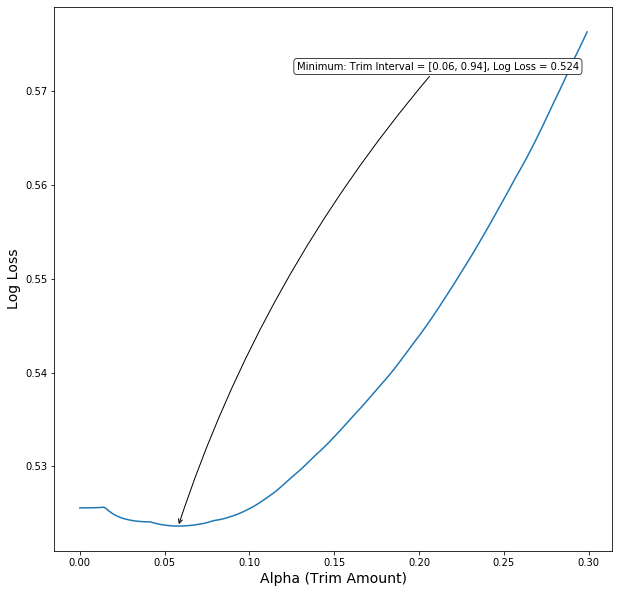

In [6]:
xvals = np.arange(0, .30, 0.001)
yvals = [trimmed_loss(alpha) for alpha in xvals]

plt.figure(figsize=(10,10))
plt.plot(xvals, yvals)
plt.xlabel('Alpha (Trim Amount)', fontsize=14)
plt.ylabel('Log Loss', fontsize=14)
annot_min(list(xvals),yvals, ax=None)
plt.show()

As it stands, our model **would** benefit from "trimming" predictions in the 2015-2019 tournaments.  Specifically, we should have bounded our predictions between 0.06 and 0.94.

Note that these tournaments had a lot of major upsets, which may be more typical in men's tournaments. Still, we may fall behind in the leaderboard very slightly by not going all the way from 0-1.  Thinking a compromise going to 0.05-0.95 will work alright on the men's side.